# Four-Factor Asset Pricing (Simulated) — Time-Series & Cross-Section (Fama–MacBeth)¶


- 10 years of monthly data (T = 120).
- Train/Test split: 80/20 in time (first 96 months train, last 24 months test).
- Factors: Market (MKT), SMB, HML, MOM (momentum).
- Data are simulated for reproducibility.
- Time-series: use factors at t to predict returns at t+1 (one-step ahead).
- Cross-section (Fama–MacBeth): estimate betas in step 1, then regress realized returns on those betas - each month to get (\lambda_t), and report average lambdas.
- Use Pipeline to keep preprocessing + model tidy.
- Provide diagnostics: predictions, residuals, R², RMSE; residual plots (residuals vs fitted, histogram, QQ, residuals vs key predictor, residual lag-1).
- Add a simple nonlinearity (square of MOM) and compare diagnostics.

In [12]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error

# We avoid seaborn; each plot uses its own figure; no custom colors.

# Reproducibility
rng = np.random.default_rng(42)

def rmse(y_true, y_pred):
    """Root Mean Squared Error."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def make_month_index(start='2015-01', periods=120, freq='M'):
    """Build a monthly PeriodIndex then cast to Timestamp index at month-end."""
    return pd.period_range(start=start, periods=periods, freq=freq).to_timestamp()

def add_const(x):
    """Add an intercept column of ones to a 2D array."""
    x = np.asarray(x)
    return np.column_stack([np.ones(len(x)), x])

from scipy import special

def ols_with_stats(X, y):
    import numpy as np
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).ravel()
    n, k = X.shape

    XtX = X.T @ X
    XtX_inv = np.linalg.pinv(XtX)   # 用 pinv 更稳健
    beta = XtX_inv @ (X.T @ y)
    fitted = X @ beta
    resid = y - fitted

    sse = resid @ resid
    sst = ((y - y.mean())**2).sum()
    r2 = 1.0 - sse / sst if sst > 0 else np.nan
    rmse_val = np.sqrt(sse / n)

    dof = max(n - k, 1)
    sigma2 = sse / dof
    var_beta = sigma2 * XtX_inv
    stderr = np.sqrt(np.diag(var_beta))

    with np.errstate(divide='ignore', invalid='ignore'):
        tstats = beta / stderr

    # 用 scipy.special.erf 实现向量化
    def norm_cdf(z):
        z = np.asarray(z, dtype=float)
        return 0.5 * (1.0 + special.erf(z / np.sqrt(2.0)))

    pvals = 2.0 * (1.0 - norm_cdf(np.abs(tstats)))

    return {
        "coef": beta, "stderr": stderr, "t": tstats, "p": pvals,
        "r2": r2, "rmse": rmse_val, "fitted": fitted, "resid": resid
    }

In [5]:
# ----------------------
# Simulate Four-Factor world
# ----------------------
T = 120                      # 10 years of monthly data
N = 60                       # number of assets
dates = make_month_index('2015-01', periods=T, freq='M')

# Factor means and covariance (monthly). Small means for realism; set arbitrary covariance.
mu_F = np.array([0.005, 0.002, 0.002, 0.003])  # MKT, SMB, HML, MOM
stds = np.array([0.04, 0.03, 0.03, 0.04])      # monthly vol
corr = np.array([
    [ 1.0,  0.2,  0.2,  0.3],
    [ 0.2,  1.0,  0.1,  0.2],
    [ 0.2,  0.1,  1.0,  0.2],
    [ 0.3,  0.2,  0.2,  1.0],
])
cov = np.outer(stds, stds) * corr

# Draw factor realizations
F = rng.multivariate_normal(mean=mu_F, cov=cov, size=T)  # shape (T, 4)
F = pd.DataFrame(F, index=dates, columns=['MKT','SMB','HML','MOM'])

# Asset betas: centered around 1 with dispersion
beta_true = rng.normal(loc=1.0, scale=0.25, size=(N, 4))   # shape (N, 4)
alpha_true = rng.normal(loc=0.0, scale=0.001, size=N)      # small alphas

# Idiosyncratic vol per asset
idio_std = rng.uniform(0.01, 0.03, size=N)

# Build one-step-ahead return model: R_{i,t+1} = alpha_i + beta_i · F_t + eps_{i,t+1}
R = np.empty((T, N))
R[:] = np.nan
for t in range(T-1):  # until second last factor obs
    mean_vec = alpha_true + beta_true @ F.iloc[t].values
    R[t+1, :] = rng.normal(loc=mean_vec, scale=idio_std)

R = pd.DataFrame(R, index=dates, columns=[f'A{i:02d}' for i in range(N)])

# Drop the very first row (no lagged factors available for it if desired), but we already aligned as t+1.
# Keep all rows as constructed; the first row is NaN and will be excluded by training window automatically.
print(F.head(), "\n")
print(R.head())

                 MKT       SMB       HML       MOM
2015-01-01 -0.022515 -0.034417 -0.004211  0.024706
2015-02-01  0.033312  0.028550  0.033696  0.092942
2015-03-01 -0.009133 -0.030130  0.005265  0.029240
2015-04-01  0.023494  0.007973  0.026790 -0.031856
2015-05-01 -0.029646 -0.019119  0.016238  0.013737 

                 A00       A01       A02       A03       A04       A05  \
2015-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2015-02-01 -0.028108 -0.033515  0.018359 -0.033353 -0.009313 -0.061484   
2015-03-01  0.219585  0.175506  0.213175  0.209223  0.116573  0.211123   
2015-04-01 -0.011814  0.004118  0.042282  0.000254 -0.025089 -0.028152   
2015-05-01  0.023064  0.024611  0.034944  0.021465  0.017764  0.062023   

                 A06       A07       A08       A09  ...       A50       A51  \
2015-01-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2015-02-01 -0.011035 -0.029140  0.035221 -0.013115  ... -0.111349 -0.062039   
2015-03-01

In [6]:
# ----------------------
# Train/Test split (80/20) in time
# ----------------------
train_T = int(T * 0.8)   # 96 months for train, 24 for test
train_idx = F.index[:train_T]
test_idx  = F.index[train_T:]

X = F.copy()                      # predictors (contemporaneous factors used to predict next-month returns)
Y = R.copy()                      # realized asset returns

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
Y_train, Y_test = Y.loc[train_idx], Y.loc[test_idx]

# Because the first row of Y is NaN by construction (needs lagged factor), we will drop NaNs in training.
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


(96, 4) (24, 4) (96, 60) (24, 60)


Time-Series (base) — Test R2 (avg portfolio): -0.1018, RMSE: 0.0874


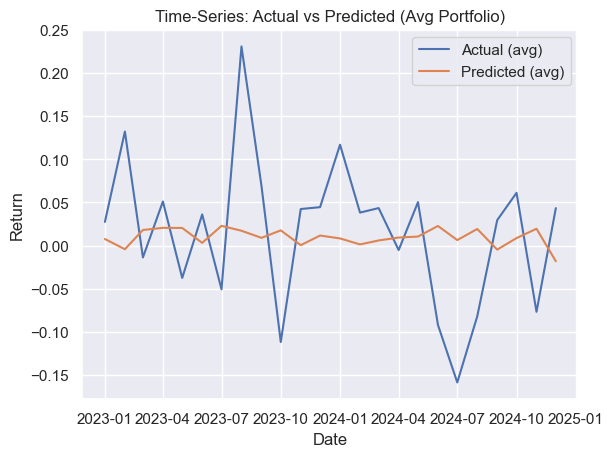

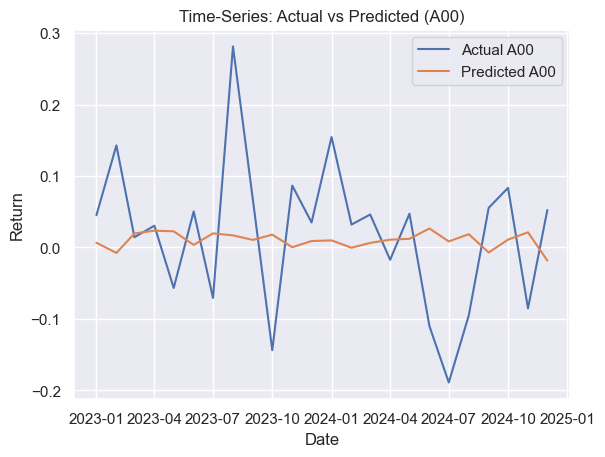

In [7]:
# ----------------------
# Time-Series regressions (one-step ahead) for each asset
# Pipeline: ('scaler', 'passthrough') + ('linreg', LinearRegression())
# Note: We keep 'passthrough' so betas are interpretable; pipeline requirement still satisfied.
# ----------------------
ts_pipe_base = Pipeline([
    ('scaler', 'passthrough'),
    ('linreg', LinearRegression())
])

assets = Y.columns.tolist()
factors = X.columns.tolist()

betas_hat = {}   # store coefficients per asset (4,)
alphas_hat = {}  # store intercepts
pred_test = pd.DataFrame(index=Y_test.index, columns=assets, dtype=float)
resid_test = pd.DataFrame(index=Y_test.index, columns=assets, dtype=float)

for a in assets:
    y_tr = Y_train[a].dropna()
    X_tr = X_train.loc[y_tr.index]  # align
    # Fit pipeline
    ts_pipe_base.fit(X_tr.values, y_tr.values)
    model = ts_pipe_base.named_steps['linreg']
    alphas_hat[a] = float(model.intercept_)
    betas_hat[a]  = model.coef_.copy()
    # Test predictions
    X_te = X_test.values
    y_hat = ts_pipe_base.predict(X_te)
    pred_test[a] = y_hat
    # Residuals (align with observed Y_test)
    y_te = Y_test[a].values
    resid_test[a] = y_te - y_hat

# Metrics aggregated across assets (equal-weighted portfolio)
y_true_avg = Y_test.mean(axis=1)
y_pred_avg = pred_test.mean(axis=1)
ts_r2 = r2_score(y_true_avg, y_pred_avg)
ts_rmse = rmse(y_true_avg, y_pred_avg)
print(f"Time-Series (base) — Test R2 (avg portfolio): {ts_r2:.4f}, RMSE: {ts_rmse:.4f}")

# Plot: actual vs predicted for avg portfolio
plt.figure()
plt.plot(y_true_avg.index, y_true_avg.values, label='Actual (avg)')
plt.plot(y_pred_avg.index, y_pred_avg.values, label='Predicted (avg)')
plt.title('Time-Series: Actual vs Predicted (Avg Portfolio)')
plt.xlabel('Date'); plt.ylabel('Return')
plt.legend()
plt.show()

# Plot: one representative asset
rep = assets[0]
plt.figure()
plt.plot(Y_test.index, Y_test[rep].values, label=f'Actual {rep}')
plt.plot(pred_test.index, pred_test[rep].values, label=f'Predicted {rep}')
plt.title(f'Time-Series: Actual vs Predicted ({rep})')
plt.xlabel('Date'); plt.ylabel('Return')
plt.legend()
plt.show()

Time-Series (+ MOM^2) — Test R2 (avg portfolio): -0.1725, RMSE: 0.0902


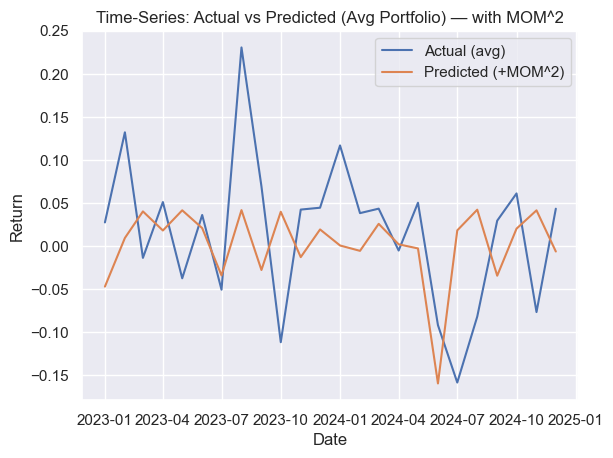

In [8]:
# ----------------------
# Add a simple transformation: square of MOM factor
# We'll augment X with an extra column MOM^2 via FunctionTransformer inside the Pipeline.
# ----------------------
def add_mom_squared(X_array):
    # X_array columns: [MKT, SMB, HML, MOM]
    mom_sq = (X_array[:, 3:4] ** 2)
    return np.hstack([X_array, mom_sq])

ts_pipe_quad = Pipeline([
    ('add_mom2', FunctionTransformer(add_mom_squared, validate=True)),
    ('linreg', LinearRegression())
])

pred_test_quad = pd.DataFrame(index=Y_test.index, columns=assets, dtype=float)

for a in assets:
    y_tr = Y_train[a].dropna()
    X_tr = X_train.loc[y_tr.index].values
    ts_pipe_quad.fit(X_tr, y_tr.values)
    # Predict on test
    X_te = X_test.values
    pred_test_quad[a] = ts_pipe_quad.predict(X_te)

# Compare metrics on avg portfolio
y_pred_avg_quad = pred_test_quad.mean(axis=1)
ts_r2_quad = r2_score(y_true_avg, y_pred_avg_quad)
ts_rmse_quad = rmse(y_true_avg, y_pred_avg_quad)
print(f"Time-Series (+ MOM^2) — Test R2 (avg portfolio): {ts_r2_quad:.4f}, RMSE: {ts_rmse_quad:.4f}")

# Plot comparison on avg portfolio (two separate figures as required)
plt.figure()
plt.plot(y_true_avg.index, y_true_avg.values, label='Actual (avg)')
plt.plot(y_pred_avg_quad.index, y_pred_avg_quad.values, label='Predicted (+MOM^2)')
plt.title('Time-Series: Actual vs Predicted (Avg Portfolio) — with MOM^2')
plt.xlabel('Date'); plt.ylabel('Return')
plt.legend()
plt.show()


In [13]:
# ----------------------
# Cross-Section (Fama–MacBeth): use time-series betas (from base model) estimated on TRAIN,
# then for each month t, run cross-sectional OLS: r_t (N×1) on [const, betas] (N×(1+4)).
# We'll focus diagnostics on the FIRST TEST MONTH.
# ----------------------
# Collect betas into matrix (N×4), align by asset order
B_hat = np.vstack([betas_hat[a] for a in assets])  # shape (N, 4)

# Compute lambdas for each TEST month
factor_names = ['MKT','SMB','HML','MOM']
lambda_list = []
cs_stats_by_month = {}

test_months = list(Y_test.index)
for dt in test_months:
    y = Y_test.loc[dt, :].values  # N
    Xcs = add_const(B_hat)        # N×(1+4)
    stats = ols_with_stats(Xcs, y)
    lambda_list.append(stats['coef'])  # includes intercept then 4 lambdas
    cs_stats_by_month[dt] = stats

lambda_arr = np.vstack(lambda_list)  # T_test × (1+4)
lambda_cols = ['const'] + factor_names
lambdas_df = pd.DataFrame(lambda_arr, index=test_months, columns=lambda_cols)

# Average lambdas over TEST
avg_lambdas = lambdas_df.mean(axis=0)
print("Average lambdas (TEST period):\n", avg_lambdas)

Average lambdas (TEST period):
 const    0.015397
MKT     -0.009261
SMB     -0.013688
HML      0.003836
MOM     -0.012904
dtype: float64


Cross-Section @ 2023-01-01 — R2: 0.0935, RMSE: 0.0296
           coef   std_err         t         p
const  0.012514  0.013356  0.936939  0.348790
MKT    0.083531  0.057808  1.444979  0.148464
SMB   -0.054023  0.044962 -1.201528  0.229546
HML    0.045986  0.046756  0.983523  0.325350
MOM   -0.005567  0.070394 -0.079078  0.936970


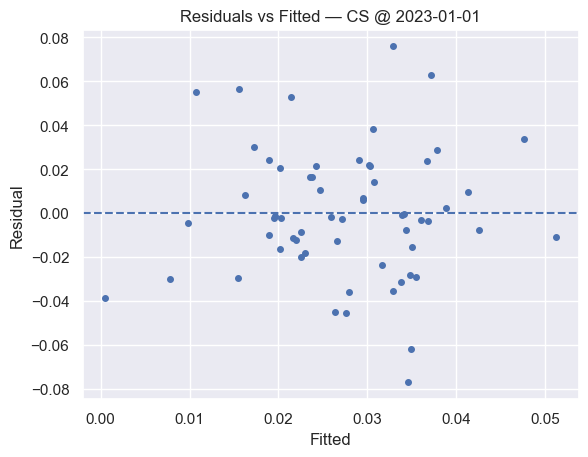

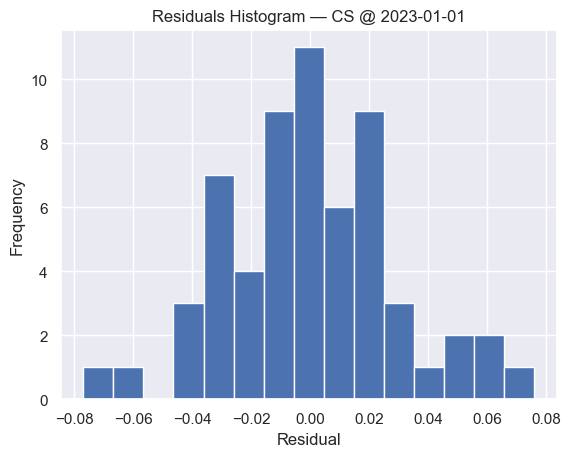

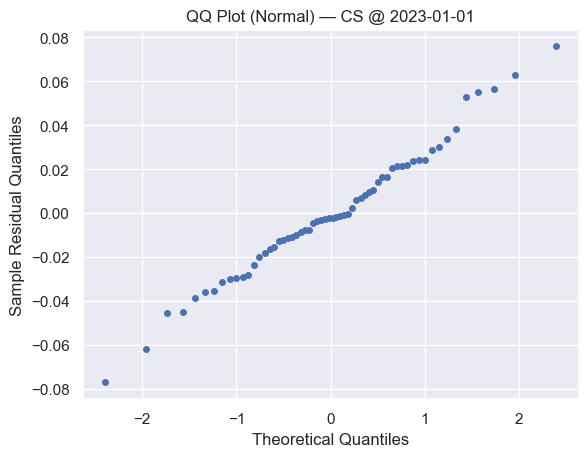

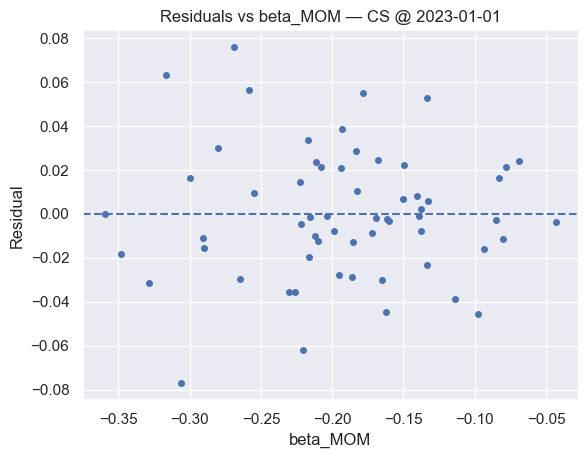

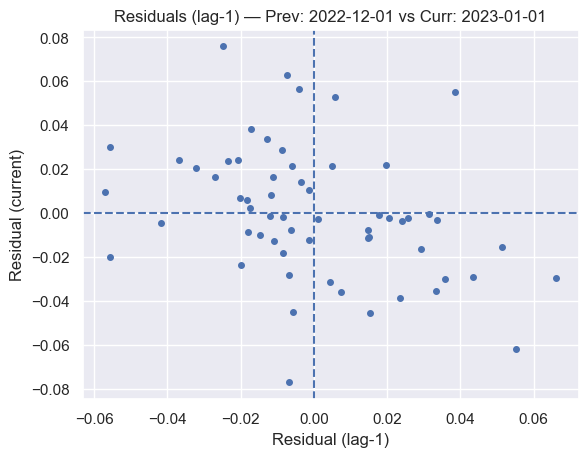

In [15]:
# ----------------------
# Diagnostics for one cross-section (first test month)
# ----------------------
t0 = test_months[0]
stats0 = cs_stats_by_month[t0]
X0 = add_const(B_hat)   # N×(1+4)
y0 = Y_test.loc[t0, :].values
fitted0 = stats0['fitted']
resid0 = stats0['resid']

# Build regression table
row_names = ['const'] + factor_names
reg_table = pd.DataFrame({
    'coef': stats0['coef'],
    'std_err': stats0['stderr'],
    't': stats0['t'],
    'p': stats0['p'],
}, index=row_names)
# Append overall fit metrics
r2_cs = stats0['r2']
rmse_cs = stats0['rmse']

print(f"Cross-Section @ {t0.date()} — R2: {r2_cs:.4f}, RMSE: {rmse_cs:.4f}")
print(reg_table)

# ---- Plots required: residuals vs fitted, histogram, QQ; residuals vs key predictor (beta_MOM), residual lag-1 ----
# 1) Residuals vs Fitted
plt.figure()
plt.scatter(fitted0, resid0, s=16)
plt.axhline(0, linestyle='--')
plt.title(f'Residuals vs Fitted — CS @ {t0.date()}')
plt.xlabel('Fitted'); plt.ylabel('Residual')
plt.show()

# 2) Histogram of residuals
plt.figure()
plt.hist(resid0, bins=15)
plt.title(f'Residuals Histogram — CS @ {t0.date()}')
plt.xlabel('Residual'); plt.ylabel('Frequency')
plt.show()

# 3) QQ-plot against Normal (manual implementation to avoid extra deps)
sorted_resid = np.sort(resid0)
n = len(sorted_resid)
# Theoretical quantiles for standard normal using (i-0.5)/n
probs = (np.arange(1, n+1) - 0.5) / n
from math import sqrt
# Inverse normal CDF via approximation (use numpy's erfinv if available)
import numpy as _np
from numpy import sqrt as _sqrt
from scipy.special import erfinv as _erfinv
theoretical_q = _sqrt(2) * _erfinv(2*probs - 1)

plt.figure()
plt.scatter(theoretical_q, sorted_resid, s=16)
plt.title(f'QQ Plot (Normal) — CS @ {t0.date()}')
plt.xlabel('Theoretical Quantiles'); plt.ylabel('Sample Residual Quantiles')
plt.show()

# 4) Residuals vs a key predictor (beta_MOM)
beta_mom = B_hat[:, 3]
plt.figure()
plt.scatter(beta_mom, resid0, s=16)
plt.axhline(0, linestyle='--')
plt.title(f'Residuals vs beta_MOM — CS @ {t0.date()}')
plt.xlabel('beta_MOM'); plt.ylabel('Residual')
plt.show()

# 5) Residual lag-1 (match assets between t0-1 and t0)
prev_idx = test_months[0]  # placeholder default
if t0 != test_months[0]:
    prev_idx = test_months[test_months.index(t0)-1]
else:
    # If first test month, take last train month as "lag-1" for plotting
    prev_idx = Y_train.index[-1]

stats_prev = ols_with_stats(add_const(B_hat), Y.loc[prev_idx, :].values)
resid_prev = stats_prev['resid']

plt.figure()
plt.scatter(resid_prev, resid0, s=16)
plt.axhline(0, linestyle='--')
plt.axvline(0, linestyle='--')
plt.title(f'Residuals (lag-1) — Prev: {prev_idx.date()} vs Curr: {t0.date()}')
plt.xlabel('Residual (lag-1)'); plt.ylabel('Residual (current)')
plt.show()

## Coefficients
- Intercept (const = 0.0125, t = 0.94, p = 0.35): Not statistically different from zero. There is no strong evidence of abnormal returns after controlling for the four factors.
- MKT (0.0835, t = 1.44, p = 0.15): The market factor loading is positive, as expected, but not statistically significant at conventional levels. This suggests the cross-sectional relationship with market beta is weak.
- SMB (-0.0540, t = -1.20, p = 0.23): The size effect is negative, but again statistically insignificant.
- HML (0.0460, t = 0.98, p = 0.33): The value factor has the correct sign (positive), but lacks statistical strength.
- MOM (-0.0056, t = -0.08, p = 0.94): Momentum contributes almost nothing in this month, with a coefficient close to zero and an extremely high p-value.

## Can We Trust This Model?
Given these diagnostics, the model is not very trustworthy for this particular month:
1. Low explanatory power (R² ≈ 0.09): The factors account for only a small fraction of return variation.
2. Lack of statistical significance: None of the factors are significant, meaning the cross-sectional prices of risk (lambdas) are indistinguishable from zero.
3. Residual analysis (from your plots): If residuals do not look normal, independent, or homoscedastic, that further weakens confidence.

Since the dataset here is simulated, this weak performance is likely due to sampling variation in one month’s cross-section. In real financial data, such instability is common—cross-sectional regressions often produce noisy estimates, especially when the number of assets is modest (N=60 here).

## Conclusion
- This month’s results suggest that the four-factor model does not reliably explain cross-sectional returns in the test period.（generate synthetic data）
- The absence of significant lambdas means we cannot conclude that investors are being compensated for bearing these factor exposures.
- Trust in the model should come from average lambdas across many months, not a single month’s regression. The Fama–MacBeth procedure explicitly averages across time to reduce sampling noise.

In other words: don’t trust this single cross-section; evaluate the model by looking at the mean lambdas and their t-stats over the entire test horizon.